## Description:
######Model type = LSTM
######Hidden layers = 1024*2
######train seq_len = 200
######model id = rnn1024t-200, actually using lstm 1024



In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import DataLoader
import torch.utils.data as data

import matplotlib.pyplot as plt
import numpy as np

import io

In [0]:
#mount google drive on colab for saving pytorch model variables
from google.colab import drive
import os
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


Data Loading

In [0]:
data_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/data/shakespeare_train.txt"
test_data_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/data/shakespeare_valid.txt"
model_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/model/"
with io.open(data_path, 'r', encoding = 'utf8') as f:
    text = f.read()
with io.open(test_data_path, 'r', encoding = 'utf8') as f:
    test_text = f.read()

chars = set(text)
tchars = set(test_text)
char2int = {c:i for i,c in enumerate(chars)}
int2char = dict(enumerate(chars))
nptext = np.array([char2int[ch] for ch in text])
npttext = np.array([char2int[ch] for ch in test_text])

N = nptext.shape[0]
tN = npttext.shape[0]
Nc = len(chars)
tNc = len(tchars)
for ele in tchars:
    assert(ele in chars)
print("all elememts in test data is in train data")
print("total train data length = {}, there are {} kinds of character".format(N, Nc))
print("total test data length = {}, there are {} kinds of character".format(tN, tNc))

all elememts in test data is in train data
total train data length = 4351312, there are 67 kinds of character
total test data length = 222025, there are 62 kinds of character


Hyper Params


In [0]:
#data
seq_len = 200
batch_size = 50
#model:
hidden_size = 1024
n_layers = 2
#traininng:
n_epoch = 30
lr = 1e-4
dropout = 0.2
print_every = 1  #generate text per 2 epoch
plot_every = 100 #calc accuracy/loss per 100 batch
#model/record saving/loading:
LOAD = False
data_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/data/shakespeare_train.txt"
model_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/model/"
rec_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/rec/"
model_id = "rnn1024t-200" #save as 
load_model_name = None
rec_name = "rec-"+ model_id + ".pkl"
load_rec_name = "rec-"+ model_id + ".pkl"

Preprocessing Data

In [0]:
from typing import List, Union #python 3.8 requried
num = Union[int, float]
def chunks(arr, chunk_len):
    for i in range(0, len(arr) - chunk_len, chunk_len):
        yield arr[i:i + chunk_len]

def s2tensor(s: str, device: str) -> torch.LongTensor:
    return torch.Tensor([char2int[s[i]] if s[i] in char2int else 0 for i in range(len(s))]).long().to(device)

def tensor2s(t: torch.Tensor) -> str:
    val = t.cpu().detach().numpy()
    ret = "" 
    return ret.join([int2char[val[i]] for i in range(len(val))])

#preprocessing train data:
seqs = list(chunks(nptext, seq_len + 1))
batches = list(chunks(seqs, batch_size))
train_data = [torch.LongTensor(batch).transpose_(0, 1) for batch in batches] #.transpose_(0, 1) => not batch first
#shape = (#batch, seqlen+1atch, batch_size)
print(len(train_data), train_data[0].shape)

#preprocessing test data:
tseqs = list(chunks(npttext, seq_len + 1))
tbatches = list(chunks(tseqs, batch_size))
test_data = [torch.LongTensor(batch).transpose_(0, 1) for batch in tbatches] #.transpose_(0, 1) => not batch first
#shape = (#batch, seqlen+1atch, batch_size)
print(len(test_data), test_data[0].shape)
#rint(tensor2s(test_data[0].transpose_(0, 1)[0]))

432 torch.Size([201, 50])
22 torch.Size([201, 50])


Model

In [0]:
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, cell_type="rnn", n_layers=2, drop_out=0.2):
        super(CharRNN, self).__init__()
        self.cell_type = cell_type.lower()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        if self.cell_type == "rnn":
            self.rnn = nn.RNN(hidden_size, hidden_size, n_layers, dropout=dropout)
        elif self.cell_type == "lstm":
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers, dropout=dropout)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded, hidden) #print(output.shape)
        output = self.decoder(output) #print(output.shape)
        return output, hidden
    def forwardc(self, input, hidden, device='cpu'): #for characters : torch([long]) to distribution
        input = input.view(1, 1).to(device) #batch = 1, len = 1 #need to be added:to(device)
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded, hidden)
        output = self.decoder(output)
        output = output.view(self.input_size)
        #print(output)
        return output, hidden

    def init_hidden(self, batch_size=batch_size, device='cpu'):
        if self.cell_type == "lstm":
            return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)))
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device))

Generate Prediction with temparature


In [0]:
def generate(model, device='cpu', seed='Juliet', predict_len=150, tau=0.8): 
    seed_tensor = s2tensor(seed, device) #shape = torch.Size([seqlen])
    #generate hidden 
    h = model.init_hidden(batch_size=1, device=device)
    for x in seed_tensor:
        _, h = model.forwardc(x, h, device)
    #generate seq
    inc = seed_tensor[-1]
    ret = seed
    for i in range(predict_len):
        out, h =  model.forwardc(inc, h, device)
        if tau >= 0.2 :
            tau_distribution = out.detach().data.view(-1).div(tau).exp()
            predi = torch.multinomial(tau_distribution, 1)[0]
        else : #prevent overflow
            _, predi = torch.max(out.detach().data, 0)
        ret += int2char[predi.item()]
        inc = torch.LongTensor([predi])
    return ret

In [0]:
def calc_accuracy(model, data, n_batch=10, device='cpu'):
    #eval accuracy for model on data with n_batch random batches, rach batch itself is continueous
    l = np.random.randint(0, len(data)-n_batch)
    r = l+n_batch
    correct_predictions = 0.0
    total = 0.0
    for batch_tensor in data[l:r]:
        hidden = model.init_hidden(batch_size=batch_tensor.size(1), device=device)
        input_variable = Variable(batch_tensor[:-1]).to(device)
        target_variable = Variable(batch_tensor[1:].contiguous().view(-1)).to(device) #print(target_variable.shape) #(batch_size*seq_len)
        # prediction and calculate loss
        output, _ = model(input_variable, hidden)
        output = output.view(-1,Nc) #(batch_size*seq_len, Nc)
        _, predicted = torch.max(output.data, 1)
        #print(tensor2s(predicted))
        total += predicted.size(0)
        correct_predictions += (predicted.long() == target_variable.long()).sum()
    return (correct_predictions/total).item()

In [0]:
def random_train_seq(model, data, seq_len=seq_len, device='cpu', random=False): #npttext, 200 #0,300 #can use param to set random = True 
    if random:
        l = np.random.randint(0, len(data)-seq_len-2)
    else:
        l = 0
    r = l + seq_len +1
    testseq = data[l:r] #np
    testtensor = torch.LongTensor(testseq).view(seq_len+1, 1).to(device)

    hidden = model.init_hidden(batch_size=1, device=device)
    inp = testtensor[:-1]
    output, _ = model(inp, hidden)
    #print(output.size()) #200, 1, 67
    _, predicted = torch.max(output.data, 2)
    print("----------input data----------")
    #print(inp.size())
    print(tensor2s(inp.transpose_(0,1)[0])) #l:r
    print("----------prediction----------")
    #print(predicted.size())
    print(tensor2s(predicted.transpose_(0,1)[0]))


Test Functionality

In [0]:
def test_model(cell_type="rnn", device='cpu'): #not training/loaded model,create new to test
    print("testing {} model".format(cell_type))
    model = CharRNN(Nc, hidden_size, Nc, cell_type=cell_type, n_layers=2)
    model.to(device)
    print("test forward")
    tout, thidden = model(train_data[0].to(device), model.init_hidden(batch_size, device))
    if cell_type=="rnn":
        print(tout.shape, thidden.shape)
    else:
        print(tout.shape, thidden[0].shape, thidden[1].shape)
    print("test forwardc")
    tout, thidden = model.forwardc(torch.LongTensor([45]).to(device), model.init_hidden(1, device), device)
    if cell_type=="rnn":
        print(tout.shape, thidden.shape)
    else:
        print(tout.shape, thidden[0].shape, thidden[1].shape)
    print("test cal_accuracy")
    print(calc_accuracy(model, test_data, n_batch=10, device=device))
    print("test random train seq")
    random_train_seq(model, npttext, seq_len=seq_len, device=device)
    print("test generate with forwardc")
    print(generate(model, device, tau=0.1), '\n')
test_model("rnn", "cpu")
test_model("lstm", "cpu")

testing rnn model
test forward
torch.Size([201, 50, 67]) torch.Size([2, 50, 1024])
test forwardc
torch.Size([67]) torch.Size([2, 1, 1024])
test cal_accuracy
0.014050000347197056
test random train seq
----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
V[ZlcZM&$u'Dxph
,ngYF]no.qTgbnQJgYdhYhQ'$-bXbQ!kEn?xWxmzbZBbBoB:pY.dJ.x!!bATyu-bDYHaJ.E$&Mkx!.:.MyX:.,jNbxyekYYCtg&
3ybgb-.lge!w3!3y!bjECPpybyjPmneydqdqUTaPagknn-bJyhPPAWkb.,$[O:!.ya:FY3J?,pFanp&$hZT:
test generate with forwardc
JulietB[[MKzDM[s3xR,qwUoQlk;fuB]MKkE?sYvieR3&wpY:P.&AbJsYGGr s3GFh:wUeJB]PbxMpX.Di&uH3JGWV3?tjm3yuYaygNzjhqweJlfpx3ELUxoQ]rzjtqwecs3?bYH;DZkZN3ayMLqpxSI$ye, 

testing lstm model
test forward
torch.Size([201, 50, 67]) torch.Size([2, 50, 1024]) torch.Size([2, 50, 1024])
test forwardc
torch.Size([67]) torch.Si

Train

Build new model

In [0]:
if not LOAD:
    model = CharRNN(Nc, hidden_size, Nc, cell_type="lstm", n_layers=2) #omg
    record = {
        'loss' : [],
        'trainAC' : [],
        'testAC' : []
    }
    print("new model and record initted")

new model and record initted


Load saved model

In [0]:
if LOAD:
    model = CharRNN(Nc, hidden_size, Nc, cell_type="lstm", n_layers=2)
    model.load_state_dict(torch.load(model_path+load_model_name)['model'])
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer.load_state_dict(torch.load(model_path+load_model_name)['optimizer'])
    print('Model parameters loaded from disk.')
    import pickle
    with open(rec_path+load_rec_name, "rb") as fo: 
        record = pickle.load(fo)
    print('Records loaded from disk.')

Use GPU if available

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print("model device : ", device)

model device :  cuda:0


In [0]:
import tqdm #set position and leave for colab
import time

def train():
    if not LOAD: 
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.CrossEntropyLoss()
    hidden = model.init_hidden(batch_size, device)
    try:
        #epoch_progress = tqdm.tqdm(range(1, n_epoch + 1),position=0, leave=True)
        best_ep_loss = float('inf')
        for epoch in range(1, n_epoch + 1):
            np.random.shuffle(train_data)
            batches_progress = tqdm.tqdm(train_data, position=0, leave=True)
            ep_loss = 0.0
            ep_train_ac = 0.0
            ep_test_ac = 0.0
            cnt = 0.0
            for batch, batch_tensor in enumerate(batches_progress):
                model.train() #########
                # reset gradients
                model.zero_grad()
                # data
                input_variable = Variable(batch_tensor[:-1]).to(device)
                target_variable = Variable(batch_tensor[1:].contiguous().view(-1)).to(device) #print(target_variable.shape) #(batch_size*seq_len)
                # prediction
                output, _ = model(input_variable, hidden)
                output = output.view(-1,Nc) #(batch_size*seq_len, Nc)
                #loss and backward
                loss = loss_function(output, target_variable)
                loss.backward()
                optimizer.step()
                model.eval() #########
                #record
                if batch%plot_every == 0:
                    _, predicted = torch.max(output.data, 1)
                    total = predicted.size(0)
                    correct_predictions = (predicted.long() == target_variable.long()).sum()
                    train_ac = (correct_predictions*1.0/total).item()
                    test_ac = calc_accuracy(model, test_data, n_batch=1, device=device)
                    loss = loss.item()
                    record['loss'].append(loss), record['trainAC'].append(train_ac), record['testAC'].append(test_ac)
                    ep_loss += loss
                    ep_train_ac += train_ac
                    ep_test_ac += test_ac
                    cnt += 1.0
                    batches_progress.set_postfix(loss='{:.03f}'.format(loss), train_ac='{:.03f}'.format(train_ac), test_ac='{:.03f}'.format(test_ac))

            #epoch_progress.set_postfix(loss='{:.03f}'.format(ep_loss))
            ep_loss /= cnt
            ep_train_ac /= cnt
            ep_test_ac /= cnt
            best_ep_loss = min(best_ep_loss, loss)
            #generate some ep string
            #time.sleep(0.01)
            tqdm.tqdm.write("\nAt {} epoche, loss = {:.03f}, train ac = {:.03f}, test ac = {:.03f}".format(epoch, ep_loss, ep_train_ac, ep_test_ac))
            seed = 'Juliet'
            tqdm.tqdm.write("RNN write with seed {}".format(seed))
            tqdm.tqdm.write("\n##############################\n")
            tqdm.tqdm.write(generate(model, device, seed, 150))
            tqdm.tqdm.write("\n##############################\n")
            tqdm.tqdm.write("\nrandom test data and prediction:\n")
            random_train_seq(model, npttext, seq_len=seq_len, device=device)
            tqdm.tqdm.write("\n##############################\n")
            
            #save best model in ep as checkpoint
            if loss == best_ep_loss:
                checkpoint_path = os.path.join(model_path, model_id+'checkpoint_ep_'+str(epoch))+ str('{:.03f}'.format(loss)) + '.cp'
                torch.save({
                    'model': model.state_dict(),
                    'optimizer': optimizer.state_dict()
                }, checkpoint_path)

    except KeyboardInterrupt:
        pass

    #save
    model.eval()
    final_path = os.path.join(model_path, model_id+'final_checkpoint_')+ str('{:.03f}'.format(loss)) + '.cp' 
    torch.save({
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }, final_path)
    import pickle
    with open(rec_path+rec_name, "wb") as fo: #wb
        pickle.dump(record,fo)
        print('Tranning records saved to disk.')

In [0]:
train()

100%|██████████| 432/432 [01:25<00:00,  5.09it/s, loss=1.881, test_ac=0.462, train_ac=0.440]



At 1 epoche, loss = 2.515, train ac = 0.324, test ac = 0.337
RNN write with seed Juliet

##############################

Julieter,
How not so whell and to come worlqours worthou prave thee shalble live the have with at to have cause lod, proassion his lide.

LASUS:
I blow you 

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
 S  I  ::::
W  tystnete the sorr tf tore  aray tf  Aode te tntent af tn  ahet  ahceern og  Ahe snper oe ten thnh d  and th mess

het shaann t ein  In tev tnmoong totl 
Tf tn tone tf r ta lnrttove the 

##############################



100%|██████████| 432/432 [01:24<00:00,  5.11it/s, loss=1.715, test_ac=0.485, train_ac=0.494]



At 2 epoche, loss = 1.777, train ac = 0.473, test ac = 0.472
RNN write with seed Juliet

##############################

Julieterach;
And the. So his bid ride of may
the great a trubfention. What good sare, whele,
But you masters,
We dughto come aven the thing one there,
Whow 

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
 S: IF IAE:
I  tystnete the sarl tf tive  aray tf  Tove te tncelt tf tt  ahet  aiceert og  The srperioe ten tork d  and th tod 

het thaannst ains It tev t moeng totl 
I  tn tone tf r ta larttoke the 

##############################



100%|██████████| 432/432 [01:24<00:00,  5.10it/s, loss=1.532, test_ac=0.535, train_ac=0.527]



At 3 epoche, loss = 1.584, train ac = 0.523, test ac = 0.514
RNN write with seed Juliet

##############################

Julieter, who when
I was you rold him be to this coldience and art good
morriel to away, but we bishinical; falled, and he was it;
And then are runch is the

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
 S::VF AAA:
I  yystc te she sarl of tove  arac tf  Aove me tncelsiof tt  ahet  aiceirt og 
Ahe srprrioi oen sonk d  and to sod 

het Ihaang tnains It iev t meeng ootl 
Tf tn ione tfer ta lnrtooke ahe 

##############################



100%|██████████| 432/432 [01:24<00:00,  5.11it/s, loss=1.471, test_ac=0.534, train_ac=0.558]



At 4 epoche, loss = 1.532, train ac = 0.541, test ac = 0.524
RNN write with seed Juliet

##############################

Julietes!

HAMLET:
Now leave not to convering mad;
And to conjury he wish unto my commongue
With his thought arms are. You have her mine you.

BARMOMIUS:
So

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
 S::VF AAE:
W  yystc te she sarl of tove  aray tf 
Aove me tncels tf tt  ahet  aireert og 
Tha srpeaioe oen shnk d  and to ses 

het Ihaang t ains tt iav b mesng toils
Tu tf ione tf r ta larsooke ahe 

##############################



100%|██████████| 432/432 [01:25<00:00,  5.07it/s, loss=1.465, test_ac=0.542, train_ac=0.557]



At 5 epoche, loss = 1.511, train ac = 0.546, test ac = 0.548
RNN write with seed Juliet

##############################

Julietes of Caesar sigres,
If the strange of your fashions come of thee
the full barrus blood and longnught!

HERSIA:
Never not you common me in some too,
A

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
eSE:OF AAE:
W  yystc te she sarl of tove  aray tf  Aove me tncels tf tt  ahet  ticeeit og 
Tha srpraite oen bhnk d  and to sos 

het thaang tnains tt iav b seang tois 
T  tf ione tf r ty lartooke aoe 

##############################



  0%|          | 0/432 [00:00<?, ?it/s]


At 6 epoche, loss = 1.466, train ac = 0.557, test ac = 0.549
RNN write with seed Juliet

##############################

Juliety shall be vices call him:
Will go danger they skin the blood of his son,
Who of the interprouse best ever thy profess
To the hearts of the boundly to

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
ESE:OFNAAE:
W  tyctc se she morl of tove, arac tf 
Aove me tncelsitf tt  ahet  ticeeit ng 
The srpraite oen bhgk d  and to sid.

het Ihaang tnains tt iav t meang ooil

Tn tf iane tf r ty lyrtooke ahe 

##############################



  0%|          | 0/432 [00:00<?, ?it/s]


At 7 epoche, loss = 1.386, train ac = 0.573, test ac = 0.542
RNN write with seed Juliet

##############################

Julieted at the lady
Without our womanness of this first truth
To which do lest his good brones; and therefore love
To which I will know you to play with al

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
eSE:OFAAAE:
W  tystc se she saol af tove, aray tf 
Aove me tncelsitf tt. ahet  ticeeit ng 
Tha srpetite oen bhnk n  and to mis,

het thaang tnains tt iat t seang toil,
Tn tf iane tfer ty hyrttoke ahe 

##############################



100%|██████████| 432/432 [01:25<00:00,  5.10it/s, loss=1.346, test_ac=0.565, train_ac=0.582]



At 8 epoche, loss = 1.354, train ac = 0.585, test ac = 0.556
RNN write with seed Juliet

##############################

Julieted, and he hath as
made them without with the corks of French is blown
Of his highness can do a cold ham. O, he
we that ere with him to accuse the cur

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
ESE:OF AAE:
W  tyctc te the wiol of tove, aray tn 
Aove me tncels tf tt. ahet  ticeeit ng 
The srpraite oen benk n  and to mie.

het whaang tnains tt iat b meing toil

Tn tf iane tfer ty lyrttoke ahe 

##############################



100%|██████████| 432/432 [01:25<00:00,  5.09it/s, loss=1.488, test_ac=0.586, train_ac=0.544]



At 9 epoche, loss = 1.386, train ac = 0.573, test ac = 0.571
RNN write with seed Juliet

##############################

Julieted hand to a murdian blood with her
And hold the laps for my chain tears here!
And three my catchable back as foul flies,
And surpel'd and rule parts 

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
eSE:VFAAAE:
W  tyctc se she sool af tove, tray tn  Aove me tvcelsitf tt. ahet  tireeit ng 
Tha srpeaite oan benk n  and to sid 

het whaang tnains tt iat t meing toil 
T  tf iane tner ty hyrttoke ahe 

##############################



  0%|          | 0/432 [00:00<?, ?it/s]


At 10 epoche, loss = 1.341, train ac = 0.585, test ac = 0.570
RNN write with seed Juliet

##############################

Julieted mother than they stay of the land,
Slend them, and 'tis to before her falserous,
We will hold thee Lucius, a blast of scorn
To water the interptial

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
ESE:VFTAAE:
W  tyctc se she sirl of tove, aray tn  Aove me tvcels tf tt. ahet  iiceeit ng,
The srpeaite oan benk n  and to sid 

het thaang tnains tt iat t seing ooil 
Tu tf iane tfer ty syrttoke ahe 

##############################



100%|██████████| 432/432 [01:24<00:00,  5.10it/s, loss=1.338, test_ac=0.577, train_ac=0.583]



At 11 epoche, loss = 1.326, train ac = 0.588, test ac = 0.573
RNN write with seed Juliet

##############################

Juliet!

REGAN:
I use not so much of his bonds against.

BULY:
No an all, to my master.

CALEBAR:
So some least amission and short-like mind
To show them li

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
ESE OF AAE:
W  tystc se she siol of tove, aray tn 
Aove me tvcels tf tt. ahet  iireeit ng 
The srpetite oay benk n  and to sie 

het thaang tnains tt iat b seing tois 
Tn tf iane tfer ty syrttoke ahe 

##############################



  0%|          | 0/432 [00:00<?, ?it/s]


At 12 epoche, loss = 1.307, train ac = 0.591, test ac = 0.574
RNN write with seed Juliet

##############################

Julieted.

KING EDWARD IV:
Say, good Murdy, for the warriar had not fourteen.
Ere that slaves, that mothers chaved the saint of part
Stand, and boys with ch

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
EME VF AAE:
W  tyctc ie she sool af tove  aray tn  Aove me tvcelsitf tt  ahet  wiceeit ng 
Ahe srprtite oan benk n  and to sod 

het whaang tnains tt iat b seing toil 
T  tf iane tf r ty syrttoke ahe 

##############################



  0%|          | 0/432 [00:00<?, ?it/s]


At 13 epoche, loss = 1.291, train ac = 0.601, test ac = 0.576
RNN write with seed Juliet

##############################

Julieted killers, and desire it so blushed ears a
stopication of a graver, masters. Who does the nurse
May be strong for these lights in the colour;
Where n

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
ESE:VFAAAA:
W  tystc se she miol af tove, aray tn  Aove me tvcels tf tt  ahet  iiceeit ng 
Tha srprtite oay benk n  and to mid 

het whaang anains tt iat b meing totl 
T  tf iane tn r ty syrsaoke ahe 

##############################



100%|██████████| 432/432 [01:25<00:00,  5.13it/s, loss=1.234, test_ac=0.575, train_ac=0.616]



At 14 epoche, loss = 1.263, train ac = 0.605, test ac = 0.577
RNN write with seed Juliet

##############################

Juliete makes a knave
Of all men back that laid me guilty and grace,
When they spails not his unmal of just-house;
With lightning mind hath seen so flint.



##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
EME VFAAAE:
I  tyctc ie she sorl of tove  Iray tn 
Aove me tvcels tf tt. ahet  iiceeit ng 
Tha srpetite oay benk n  and to mod 

het Ihaing tnains tt iat b soing toil

T, tf iane tfer ty syrstoke ahe 

##############################



  0%|          | 0/432 [00:00<?, ?it/s]


At 15 epoche, loss = 1.304, train ac = 0.596, test ac = 0.572
RNN write with seed Juliet

##############################

Julieter, is no strange to you; and your love
is not your wit to see them well, nor leave him:--

SALANIO:
It is it not worse,
We are a worthy false life ma

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
EME VFAAAA:
I  tyctc ie she mirl of move, Iray tn  Aove me tvcelsitf tt. ahet  iiceeit ng 
Ahe srprtite oay benk n  and to mod 

het whrang'onains tt iat n moing oois 
Tn tf iane tfer ty hyrstoke aoe 

##############################



  0%|          | 0/432 [00:00<?, ?it/s]


At 16 epoche, loss = 1.240, train ac = 0.611, test ac = 0.579
RNN write with seed Juliet

##############################

Julietle and holds my name and Jack,

LADY PECHET:
A mighty cousin.

BIRON:
No, no, no.

CLEOPATRA:
God by the palishman:
Only they fill them to the air, I 

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
EME VFEEAA:
W  tyctc ie she sirl of tove, Iray tn  Aove me tvcels tf tt. ahet  iiceeit ng 
The srpetite oay benk n  and to fid 

het whreng onains tt iat b boing tois,
T  tf iane tfer ty syrstike ahe 

##############################



  0%|          | 0/432 [00:00<?, ?it/s]


At 17 epoche, loss = 1.244, train ac = 0.610, test ac = 0.574
RNN write with seed Juliet

##############################

Julietle man Edward's death: your brother
Shall be our country that I know not,
Confess' health in what whom the state the least
shall be so from my soul op

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
EME VFEAAE:
I  tyctc se she sirl af tove  Iray tn  Aove me tvcels tf tt. ahet  iireeit ng 
Ihe srprtite oan benk n  and to sid 

het whrang onains tt iat b soing tois

T, tf iane tfer ty syrstike ahi 

##############################



100%|██████████| 432/432 [01:25<00:00,  5.11it/s, loss=1.255, test_ac=0.581, train_ac=0.609]



At 18 epoche, loss = 1.243, train ac = 0.612, test ac = 0.574
RNN write with seed Juliet

##############################

Julieter and here
Doth be lust and cool'd than my lord of good,
Over the war had diseased on the dog,
That will not be my sweet Talbot was the night:
The we

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
EME OFAAAA:
I  tyctc ie the sirl of tove, Iray tn  Aove me tvcels tf tt. ahet  iiceeit ng 
The srpetite oay benk n  and to sed 

het Ihaang tnains tt iat b seing tois,
T, tf iane tfer ty syrstoke ahe 

##############################



  0%|          | 0/432 [00:00<?, ?it/s]


At 19 epoche, loss = 1.240, train ac = 0.610, test ac = 0.587
RNN write with seed Juliet

##############################

Julietle close of earth,
For when his contract would be pluck thy humble.

VALENTINE:
All forward will make thee dead and lord that,
Plung thee to this part

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
EKE VFAAAA:
W  tyctc se she siol of tove, Irey tn  Aove me tvceps tf tt. ahet  iireeit ng 
The srpetite oay benk n  and to see 

het whaang onains tt iat b seing tots,
T, tf ione tfer ty syrstoke ahe 

##############################



  0%|          | 0/432 [00:00<?, ?it/s]


At 20 epoche, loss = 1.202, train ac = 0.624, test ac = 0.595
RNN write with seed Juliet

##############################

Julietle little stung upon
The sucperstitionment was done a prey;
Or, if thou think I let it be dier at him,
Condemn'd apparel to the speaking stone
Of the 

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
EKE VF AAA:
W  tyctc ie ahe siol of tove  Iray tn  Iove me tvcels tf tt. ahet  iireeit ng 
The srpetite oay btnk n  and to mid 

het whaang onains tt iat b soing mots

T, tf iane tner ty syrstoke ahi 

##############################



  0%|          | 0/432 [00:00<?, ?it/s]


At 21 epoche, loss = 1.184, train ac = 0.628, test ac = 0.585
RNN write with seed Juliet

##############################

Julieted answer,
The instant hollow protector of my son,
Than the flatterer can make me canst live.

KING HENRY VI:
And in a man may live, I will suctor the

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
EKE VFAAAAU
W  tyctc ie the mirl of tove  Iray tn  Iove me tvcels tf tt. ahet  iireeit ng 
The srprtite oay benk n  and to mid 

het ihring'onains tt iat b moing totl,
Tn tf iane tfer ty syrstike ahe 

##############################



  0%|          | 0/432 [00:00<?, ?it/s]


At 22 epoche, loss = 1.154, train ac = 0.636, test ac = 0.585
RNN write with seed Juliet

##############################

Julieta; have you not but a poor side of a
many power with day.

BRUTUS:
Not a foom to ready to you. First heat.

MENENIUS:
My Lord of Wales, I pray, sir, t

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
EKE VFVEAEU
W  yyctc ie ahe siol of move, Iray tn  Iove me tvceps tf tt. ahet  iireeit ng 
Ihe srpetite oay benk n  and te mis 

het whrangsonains tt iat b soing motl

Tn tf iane tner ty hyrstoke aoe 

##############################



  0%|          | 0/432 [00:00<?, ?it/s]


At 23 epoche, loss = 1.161, train ac = 0.634, test ac = 0.585
RNN write with seed Juliet

##############################

Julieter.

PISANIO:
My noble gods,
Thou wilt, then we bless the ground in thy charge.

BASSANIO:
No't believe at.

ANTONY:
I had rather death and seek my ba

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
EME VFEEAE:
W  tyctc we the sool of tove, Irey tn  Iove me tvcels tf tt. ahet  iireeit ng 
Ihe srprtite oay benk n  and to mod 

het whaang wnains tt iat b soing sois

T  tf iane tner ty syrstike aoo 

##############################



100%|██████████| 432/432 [01:25<00:00,  5.05it/s, loss=1.250, test_ac=0.576, train_ac=0.605]



At 24 epoche, loss = 1.173, train ac = 0.630, test ac = 0.577
RNN write with seed Juliet

##############################

Julieter--hath brought him to the stocks?
How happy will I feedly think the trybalt
That lies him at the golden head of marriage?

SURREY:
They live to be h

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
EKE VFEEAE:
W  tyctc ie the sirl of tove, Irey tn 
Aove me tvcels tf tt. thet  iireeit ng,
The srpetite oay benk n  tnd to sie 

het whaangsonains tt iat b seing totl,
T, tf iane tner ty byrstoke thoe

##############################



  0%|          | 0/432 [00:00<?, ?it/s]


At 25 epoche, loss = 1.174, train ac = 0.626, test ac = 0.592
RNN write with seed Juliet

##############################

Julieters! can the monster's doing,
Keep pity on me to the other man?
From them my heart in motions of my state!
Thou hast paid up my sword; not this in Fra

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
EKE VFAAAAU
I  tyctc ie the sirl of move, Irey tn  Iove me tvceps tf tt. ahet  iireeit ng,
Ihe srpetite oay btnk n  and to mid 

het whaing inains tt iat b soing mots,
Tn tf iane tner ty syrstike shom

##############################



  0%|          | 0/432 [00:00<?, ?it/s]


At 26 epoche, loss = 1.167, train ac = 0.631, test ac = 0.584
RNN write with seed Juliet

##############################

Julieted and most great of their virtues:
Sir John Geothe, a book, and other fortune,
Have power to come some employment. If it not,
Mine eyes are many of t

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
EKE VFAAAA:
I  tyctc we ahe sirl of move  Irey tn 
Iove me tvceps tf tt. ahet  iireeit ng,
Ihe srpetite oay benk n  and th see 

het whaing onains tt iat b seing mots

I, tf ione tner ty syrstike aoie

##############################



  0%|          | 0/432 [00:00<?, ?it/s]


At 27 epoche, loss = 1.138, train ac = 0.643, test ac = 0.597
RNN write with seed Juliet

##############################

Julieted all o'erstill us both.

Second Lord:
I pray you, for the aught I dispraised, my lord.

HAMLET:
He is not there.

ANTIPHOLUS OF EPHESUS:
And I have 

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
EME VFAAAAU
I  tyctc ie the sirl of tove, Irey tn 
Iove me tvceps tf tt. ahat  iiceeit ng,
Ihe srprtite oay btnk n  and to fid 

het thaangeonains tt iat b seing socl

Tn tf ione tner ty hyrstike thim

##############################



  0%|          | 0/432 [00:00<?, ?it/s]


At 28 epoche, loss = 1.185, train ac = 0.628, test ac = 0.592
RNN write with seed Juliet

##############################

Juliet, and a lioner that is miserable.

BALTHASAR:
Account'st the good thing ne'er a quarrel in thy life.

BRUTUS:
Prithee, come, good Kate.

Captain:
You 

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
EME VFAAAA:
I  tyctc ie the sool of tove, Iray tn  Iove me tvcels tf tt. ahet  iireeit ng,
Ihe srpetite oay btnk n  and to mid 

het Ihaang onains
tt iat b moing mocs,
T, tf ione tner ty byrstike toom

##############################



100%|██████████| 432/432 [01:25<00:00,  5.07it/s, loss=1.114, test_ac=0.568, train_ac=0.642]



At 29 epoche, loss = 1.111, train ac = 0.647, test ac = 0.584
RNN write with seed Juliet

##############################

Juliet! O my good lord cardinal,
I cannot be for your sword--

LAFEU:
He shall not be as such a strange cause of love:
We have the bereft of chosen where he

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
EKE VFVAAAU
W  tyctc we the wirl of tove, Iray tn  Iove me taceps tf tt. ahot  iireeit ng,
Ihe srpetite oay btnk n  and to med 

het whrang wnains tt iat b saing mots,
I, tf ione nner ty hyrstoke sooe

##############################



100%|██████████| 432/432 [01:25<00:00,  5.11it/s, loss=1.102, test_ac=0.597, train_ac=0.645]



At 30 epoche, loss = 1.091, train ac = 0.652, test ac = 0.597
RNN write with seed Juliet

##############################

Julieted and venturous lord:
If it is not a damned my posterior,
That we will content your over-mercy,
Whose rags are other in the world's ear,
And hither s

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
EME VFEEAEU
I  tyctc ie the sirl of tove  Irey tn  Iove me txcels tf tt. ahet  iireeit ng,
Ihe srprtite oay btnk n  and to fie 

het whrang onains tt ias b soing mots,
I  tf iane tner ty syrstike soim

##############################

Tranning records saved to disk.


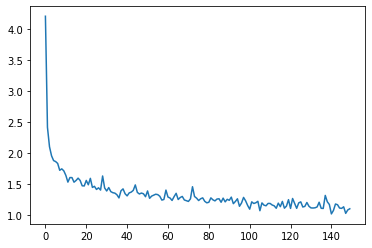

In [0]:
plt.figure()
plt.plot(record['loss'])
plt.show()

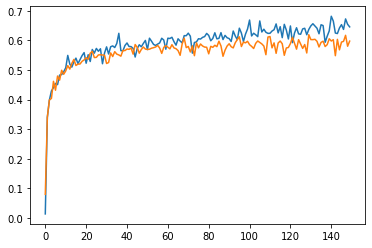

In [0]:
plt.figure()
plt.plot(record['trainAC'])
plt.plot(record['testAC'])
plt.show()

In [0]:
print(generate(model, device)) #default tau = 0.8

Julieter and uncle him that will be ashamed
To save a shoulder sorrow so trust the king,
If that I been so much in heaven hath made
A prince and my secret c


In [0]:
print(generate(model, device, seed='juliet', tau=0.1), '\n') #deterministic
print(generate(model, device, seed='juliet', tau=2), '\n') #radom

julieted parts
That they did see the strength of this deserved
And the devil hath sent forth to see the streets
And the sea of them are stronger than the st 

juliet. See-draying wannon-lors;
Nor, no, BuFinariage, fater-highiCBapvosachVer..

DUKE SOULNE:
I drow;
I am her; alder hy, a groby o
wax;
Ancide; coffow, a 



In [0]:
print(generate(model, device, seed='i will', predict_len=500, tau=0.8), '\n') #middle, produce longer

i willy.

DEMETRIUS:
I will rest there to come had amain the hour
The recorders of the world I did:
I cry thee but my blood and all the freedom;
And his little lord is not the day of all.

DESDEMONA:
And where's Talbot, the devil hast sent him?
And then, devise him, so sure the earthly part,
And then the ladies and with ruding good
Shall by his hand and stand you bent to have.

KING LEAR:
To take the foal of Troy and my faith,
When I was torn by a breath enough to die.

FLUELLEN:
I know not, neither:  



In [0]:
calc_accuracy(model, test_data, n_batch=len(test_data)-1, device=device)

0.5938809514045715

In [0]:
calc_accuracy(model, train_data, n_batch=len(test_data)-1, device=device)

0.6524666547775269

In [0]:
random_train_seq(model, nptext, seq_len=seq_len, device=device)

----------input data----------
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you
----------prediction----------
orst Sitizen:
Ae ore te saoveed i d tarther  se r me speak.

SNl:
Tieak  sieak.

Sirst Litizen:
Wou are a l teaolved tether to bis fhen th siiish


SNl:
Teaolve  
Weatlve  

Mirst Litizen:
Warst, hou 


In [0]:
random_train_seq(model, nptext, seq_len=seq_len, device=device, random=True)

----------input data----------
SUFFOLK:
That is her ransom; I deliver her;
And those two counties I will undertake
Your grace shall well and quietly enjoy.

REIGNIER:
And I again, in Henry's royal name,
As deputy unto that gracious
----------prediction----------
:RF:LK:
Ahet ws ter fensom, a wosiver tir 
And theue tho hounsrns a will bndertake
Tour hrace shall be l bpd tuiet y dndoy 

KOGGNIER:
Wnd t wmain  tn terry s heyal fame,
An Iiaety tpto thet sraceous 


In [0]:
print(generate(model, device, seed='i will', predict_len=500, tau=0.8), '\n')

i willingly in the company of France, the state
in monstrous expliaments and in the son upon a woman,
and his own discourse.
How! what mean you? what thinks you had the use of
the knave may be compassion of?

LEONATO:
Come, in the discretion of the bold is your
with a blank, but not a man for me and your majesty
is well as a brave point of many a thousand man
shall be counted confessions to speak a wither's
about, and there was in the blessed linen.

CALIBAN:
Ay, burn; I might see him but a house to h 



In [0]:
print(generate(model, device, seed='i will', predict_len=500, tau=0.8), '\n')

i willingly die a ship behind our mother's
graces, a charm that the poor pretty complexions
of as home seems as when the waste can appear it.

ANGELO:
How dost thou never heard him?

ALEXANDER:
Here is more knave, and all the galleys of the
lady go to die.

Lord Chief-Justice:
I have a more precious to be well in pity;
there is my death from his change: you might have
great power too long with great and storms, when
his son cowards is dead and way of life. An I
will never heel through the proud minist 



In [0]:
print(generate(model, device, seed='i will', predict_len=500, tau=0.4), '\n')

i willy be the streets, and she shall be
The speedy of my soul, and there is nothing
That you will stay to say so much upon you:
My lord cannot be the strong with this form,
When I shall have a sudden shame to me.

EARL OF WORCESTER:
I am a soldier, that I may speak the world
That I may see a thousand ducats that
Which should be strong and from the field of strong,
And they did see the armour of the stream
And stretch the meanest poison of the world,
That they may prove a soldier that the sense
Which  



In [0]:
print(generate(model, device, seed='i will', predict_len=500, tau=0.8), '\n')

i willy prove a truth of intellegue of her leek.
I hope
Goes to the prince apprehensions all.

IAGO:
So shall you speak to do,
And yet I know the mash were punish'd for
To spite and by the false white bed-fancing
The head of birds and misery.

BASTARD OF ORLEANS:
I thank thee hence to do.

GREMIO:
Art thou their mother there?

First Musician:
Well, they are looked but that the flood is made,
How ill our stocks be something like the spirit,
We will it not my kisse in that which majested
The speech part 



In [0]:
print(generate(model, device, seed='Lord', predict_len=500, tau=0.4), '\n')

Lordo, and be your brother.

IAGO:
I am not worthy than the father of the world.

DOMITIUS ENOBARBUS:
How now, my lord! what says the world is this?

Second Lord:
Well said, sir, the devil has a noble truth.

PRINCE HENRY:
Farewell, good father.

MENAS:
I am a son of them.

MARK ANTONY:
He is a good discontented father to his house,
And he will serve the world in his honour than
I have promised to be advised to him.

LADY MACBETH:
What is the matter?

PAROLLES:
And so shall I say he will desire to d 



In [0]:
print(generate(model, device, seed='Lord', predict_len=500, tau=0.4), '\n')

Lordo, my lord, have I done thine of this discourse
To see my son of this deserving man?

PRINCE HENRY:
What is the matter?

EDMUND:
He is a devil, and hasty than a place.

KING HENRY VI:
I do not like the sense of men that she
Her professes will be buried in the world
Which is too far for me to share a son.

LYSANDER:
I am sorry that I am a fool to seek him.

CORNWALL:
I am a good resolution and my sister,
And all the world is much for one in his discourse,
And therefore I will prove a friend to hi 



In [0]:
print(generate(model, device, seed='Flower', predict_len=500, tau=0.4), '\n')

Flowery, and be not as you are.

PARIS:
This is the name of Capulet, with all the land,
The heavens that were the sun of the king's face,
The other makes me not and dispatch.

DUKE VINCENTIO:
I am a good trumpet, and your son is so,
And I will do thee partisans to the court.

First Lord:
I am a fool, sir, but that I am sure
That is not gone to see your hands.

Second Lord:
I cannot tell them that you love me.

KING HENRY VIII:
And that we will be soldiers to his face,
And the commons are my father and 



In [0]:
print(generate(model, device, seed='Soldier', predict_len=500, tau=0.4), '\n')

Soldiery:
He is a good prince, and the more than mine eyes
Be sure of honour and my brother's house;
And then the soldiers shall his face is strange.

CARDINAL WOLSEY:
The sin of money were in their own beams,
And will not speak to him that will not be a
devil.

HAMLET:
Ay, and the third of the sea-sick lieutenant.

CALIBAN:
Ay, marry, well; I say, and thou art mine.

PETRUCHIO:
My lord, you are most near the man that you
Will do as well as the sense and my grace
To say the last sorrow is a man of him. 



In [0]:
torch.save(model, model_path+"best_model_gpu.pt")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type CharRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Embedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
modelload = torch.load(model_path+"best_model_gpu.pt")
modelload.eval()

CharRNN(
  (encoder): Embedding(67, 1024)
  (rnn): LSTM(1024, 1024, num_layers=2, dropout=0.2)
  (decoder): Linear(in_features=1024, out_features=67, bias=True)
)

In [0]:
calc_accuracy(modelload, test_data, n_batch=1, device=device)

0.6100999712944031

In [0]:
PATH = model_path+"best_model_gpu.cp"
torch.save(model.state_dict(), PATH)

In [0]:
model2 = CharRNN(Nc, 1024, Nc, 'lstm', 2, 0.2)
model2.load_state_dict(torch.load(PATH))
model2.eval()
model2.to(device)

CharRNN(
  (encoder): Embedding(67, 1024)
  (rnn): LSTM(1024, 1024, num_layers=2, dropout=0.2)
  (decoder): Linear(in_features=1024, out_features=67, bias=True)
)

In [0]:
calc_accuracy(model2, test_data, n_batch=1, device=device)

0.6205999851226807

In [0]:
print(generate(model, device, seed='Soldier', predict_len=500, tau=0.4), '\n')

Soldiery:
This is a reverend care of the duke's death.

LADY ANNE:
The cardinal's doth remember the sons
And by the strength of the hour straight shall be,
And let him find him with a first heart well.

ROSALIND:
Out, that the saints of this command the man!

CASSIUS:
And what shall I see the remedy?

SHYLOCK:
I have done my lord and great and honour,
I will not die in my strange bondman.

HELENA:
How now, my lord!

KING RICHARD III:
Why, this is the matter: he is a good father,
I thank your lordship a 



In [0]:
print(generate(model, device, seed='KING RICHARD III:', predict_len=1000, tau=0.4), '\n')

KING RICHARD III:
All that the world is dead, so far a son,
The heavens make them be acquainted with the place.

BRUTUS:
The first and white regard of your mouth
I shall be drunk and blood that show me face,
And she is not so far as you are so
As you are sent as dear.

CAPULET:
Because you are mine own dear father's house,
And therefore let me see a stranger than
What I will find him something be a soul
That I will do thee service and my sword,
But did my soul and true and play the same:
And therefore I'll sat in a sea of thine,
And there is more than a bark again.

SIR HUGH EVANS:
Good morrow, good morrow, and the duke hath brought you.

DUKE VINCENTIO:
No, not a monster.

IAGO:
What, have you gone to deny your hearts?

ANTIPHOLUS OF EPHESUS:
The cause is gone, and he was found to see him:
But how did you see how the proper spirits
Is like a dear of all the world is coming?

KING HENRY VIII:
And that will I report the story of the world,
That I should see the best of my brother,
And t

In [0]:
print(generate(model, device, seed='princess', predict_len=1000, tau=0.4), '\n')

princess of my heart:
The one be sorry that I am a good
That would be suit to her and my sword shows.

GLOUCESTER:
But this is the true death of my action,
And that the state of mine has died to thee,
And find the harmless garments of the greatest
Cannot help thee from the hand of men.

TITUS ANDRONICUS:
Sir, have you been this to me and this?

HAMLET:
There is no matter, my lord, if you are so good,
And will approve me to a proper man.

DUKE OF AUMERLE:
I know not what you have done before my spirits.

TIMON:
What is the matter, what is the matter,
That this may grow to the common proper of
And the one more better than the sharper?

ANTIPHOLUS OF EPHESUS:
Then let me see your lordship and the world
I shall discover the truth of your distress.

Second Lord:
I do beseech you, good Lord Timon, he hath
companion to the earth.

SIR HUGH EVANS:
How now, my lord! what say you this? where is the
marriage of the court?

PRINCE HENRY:
What must be so? when she was to discover him
and part of hi

In [0]:
print(generate(model, device, seed='Lin Yang Tong', predict_len=1000, tau=0.4), '\n')

Lin Yang Tonger Harry of his heart,
And bid him still his blood at home, being one.

DEMETRIUS:
The sixth of the earth doth seek the dead that did
As he are found she lived; and therefore did
A proper shepherd show the sides of them.

HELENA:
You are a soldier, and your strength and your
Are perfection to a little shall.

DIANA:
I will speak my lord and thing that I might have done.

BRUTUS:
And that shall be a true deceit of my bond;
And there I will not live to see your grace
And the good deed are the most proud of mine.

KING HENRY VI:
And therefore let us see the cause of breath.

MARK ANTONY:
The service of the spirit of the time
Is much to stand and see the sister of the night.

Second Lord:
I did not think the devil advise him there.

WARWICK:
The son of England are no more than hers.

KING HENRY VIII:
What say'st thou that?

CAMILLO:
The lady is the son of the world go with me.

DUKE OF YORK:
What is the next that thou art a tall of man,
That do approve the sun that seems to be

In [0]:
print(generate(model, device, seed='Max', predict_len=1000, tau=0.4), '\n')

Max of his own house to show his love and his
sleep; and if you will not live in his answer to
him, if you can do it, in the common hours is
better than her beauty than the world.

ANGELO:
He hath a time to speak a present and most
bond of his and most deserving-man, as it is
not a strange fire of the sea-sick.

CLEOPATRA:
The beast is this for the devil.

DUKE VINCENTIO:
And you shall have a son of the proper man.

BENEDICK:
I am a man that shall be false and drunken blood.

MARK ANTONY:
I will see this matter to the common prince,
And yet I fear the time of my desires.

LADY MACBETH:
Here is the strength of this world should be measured
And bid the heavens with all my heart be said,
And so he speaks to be no less from hence
And he that shows his son to his father's house,
And he is soldiers for his side of me.

CAPULET:
What says the name of Suffolk know the brow,
And the world gives the sense of the true?

SHALLOW:
I will be so for your love to last a proper highness
than you shall 

In [0]:
print(generate(model, device, seed='Lin Yang Tong', predict_len=500, tau=0.1), '\n')

Lin Yang Tonger stands upon him,
And the sea of the dead man is dead,
And the sense of the world is so abused.

KING HENRY VIII:
What says the matter?

MARK ANTONY:
The senate is the streets, and the strength of them
As the sea of them are stronger than the state
And the strength of the world shall be the streets.

KING HENRY VIII:
What says the matter?

MARK ANTONY:
The senate is the streets, and the strength of them
As the sea of them are stronger than the state
And the strength of the world shall be the s 



In [0]:
print(generate(model, device, seed='KING HENRY VIII:', predict_len=500, tau=0.1), '\n')

KING HENRY VIII:
The senate of the world is so about,
And the sun shall be so bold and seen the streets.

KING HENRY VIII:
What says the matter?

MARK ANTONY:
The senate is the streets, and the strength of them
As the sea of them are stronger than the state
And the strength of the world shall be the streets.

KING HENRY VIII:
What says the matter?

MARK ANTONY:
The senate is the streets, and the strength of them
As the sea of them are stronger than the state
And the strength of the world shall be the streets.

 



In [0]:
print(generate(model, device, seed='KING HENRY VI:', predict_len=500, tau=0.8), '\n')

KING HENRY VI:
And what says the best to take my death?
The most revenge may we and the such deeps
After his own desire? O, fie, gentle gentle
Lephose and trouble this riches breath to live!
The tribunes of the duke doth bear thy spirit
Go morrow than this: I, with his hour condest
All souls surfeits than the edifians are;
A married time did ran as swift as noble
O'erlands and fortune.

MACBETH:
What is the truth?

LONGAVILLE:
I do not know you before him; and if he
Will drink up to aspire him on the peace,
S 



In [0]:
print(generate(model, device, seed='I do not know you before him', predict_len=500, tau=0.4), '\n')

I do not know you before himends to him.

PAROLLES:
Sir, I think the court is a good complaint of a
man in the world after him and he will not mean you
to his country.

SHALLOW:
He hath a hard approaches in the service of
the sea-sick, the first have been a pity that
which we are suppers, and the which he bears him
to the people.

HAMLET:
O my boy, the son of his brother! he was a friend.

SIMPLE:
Why, then I say to him that has a good deed to
hear of the short.

Second Lord:
Sir, the duke will be her word to him.

ANTIPHO 



In [0]:
print(generate(model2, device, seed='My lord,', predict_len=500, tau=0.4), '\n')

My lord, the prince hath made him seem
To let him give his hand to his descent.

SILVIUS:
She hath been good morrow, and the state of men
Are not so near the chain that is mine own.

DUKE VINCENTIO:
What says the time?

DOMITIUS ENOBARBUS:
He shall not be the warrant of his son.

SUFFOLK:
Most fair and profession, if you have me speak,
But startly as he was a great summer,
And thou shalt know me in the court here in
As well as I am here.

ALL:
And here, my lord.

CASSIUS:
And what will you do it? I have 

